In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np

In [2]:
# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region us-west-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [3]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines

for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "MAKWest.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com
ssh -i "MAKWest.pem" ubuntu@ec2-127-0-0-1.us-west-1.compute.amazonaws.com


## Set number of clusters

In [4]:
nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 8


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = 2

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]




# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



2


In [5]:
clientIps, no_cluster_yet_nodes

(['127.0.0.1', '127.0.0.1'], [])

## Functions

In [6]:
def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
        os.system(command)

        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ./gradlew installDist'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S rm ../dump_files/nohup*.out; echo 1234 | sudo -S rm config*/currentView;'
        
        
        os.system(command)
        
        

        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 & echo $! > ../dump_files/jobID_s'+str(i)+'.txt'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)        
#         print(command)



def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(i-len(nodeIps)-len(no_cluster_yet_nodes))+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = ' killall java; killall nohup'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'killall java;  killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = ' nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../dump_files/nohup_s'+str(i)+'.out 2>&1 &'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../dump_files/nohup_c'+str(i)+'.out 2>&1 &'

        
        print(command)

# for i in range(len(lines)):
#     run_basic_client_check(i)



def join_node1(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11080 11081 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command)   
        
        
def join_node2(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11090 11091 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 
        
def join_node3(i):
    ip = lines[i]
    if ip!='None':
        
        current = (ip.split('.'))
        command = 'nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices '+str(i)+' 127.0.0.1 11100 11101 config0 >../dump_files/nohup_j'+str(i)+'.out 2>&1 &'
        
        
        os.system(command) 

## Compile Job

## Setup Client and nodeIPS

In [7]:
len(lines)

10

In [8]:
len(nodeIps), len(clientIps)

(8, 2)

## RUN SERVERS

In [9]:
for i in range(len(lines)):
    kill_java(i)

for i in range(len(lines)):
    clean_job(i)
    
compile_job(1)



java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
java: no process found
nohup: no process found
java(24982): Operation not permi

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 1s
3 actionable tasks: 3 up-to-date


In [10]:
    
for i in range(len(lines)-nclients-len(no_cluster_yet_nodes)):
    print(i)
    run_server_node(i)

0
1
2
3
4
5
6
7


In [11]:
time.sleep(30)
!tail ../dump_files/nohup_s0.out -n 50

-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 2 with smsg.getCID() 8 (expecting queryID 8),  waitingCID -1, isInitializing true
-- smsg.getSender() 2, smsg.getState().getLastCID() -1
-- Received 1 replies for query ID 8
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 1 with smsg.getCID() 8 (expecting queryID 8),  waitingCID -1, isInitializing true
-- smsg.getSender() 1, smsg.getState().getLastCID() -1
-- Received 2 replies for query ID 8
-- currentConsensusIdAsked activated
-- Received CID query from 3 with ID 0
-- Going to send back response to CID query with CID: -1
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@15b204a1, remoteId: 3
-- Sent CID reply to replica 3 with ID 0
-- currentConsensusIdReceived activated
-- Received  CID reply from replica ( or smsg.getSender()) 3 with smsg.getCID() 5 (expecting queryID 8),  waitingCID -1, isInitializing true

In [12]:


# for i in range(len(lines)):
#     kill_java(i)

In [13]:
len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)


10

## Run basic client

In [14]:
for i in range(len(nodeIps)+len(no_cluster_yet_nodes),len(nodeIps)+len(no_cluster_yet_nodes)+len(clientIps)):
    run_basic_client(i)

In [15]:
time.sleep(80)

In [16]:

# time.sleep(30)
# run_server_node(8)
# time.sleep(15)
# join_node1(8)

# time.sleep(30)
# run_server_node(9)

# time.sleep(30)
# join_node2(9)

# time.sleep(30)
# run_server_node(10)
# time.sleep(30)
# join_node3(10)

In [17]:
# time.sleep(50)

# run_server_node(9)

time.sleep(40)
# join_node2(9)


# for i in [2]:
#     os.system('kill -9 `cat ../dump_files/jobID_s2.txt`')
    


# time.sleep(80)



for i in range(len(lines)):
    kill_java(i)
    


java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found
java(24982): Operation not permitted
java(26248): Operation not permitted
nohup: no process found


In [18]:
# for i in range(len(lines)):
#     kill_java(i)

## Main Job

In [19]:
def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 


In [20]:
## Byzantine Remote View Change

In [21]:
times ,thputs, lats = getTimesThputs('../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out')


'../dump_files/nohup_c'+str(len(nodeIps)+len(no_cluster_yet_nodes))+'.out'

'../dump_files/nohup_c8.out'

In [22]:
# np.mean(lats[20:]) # 23604.83205128205

In [23]:
np.mean(lats[20:])

360664.3496052632

In [24]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


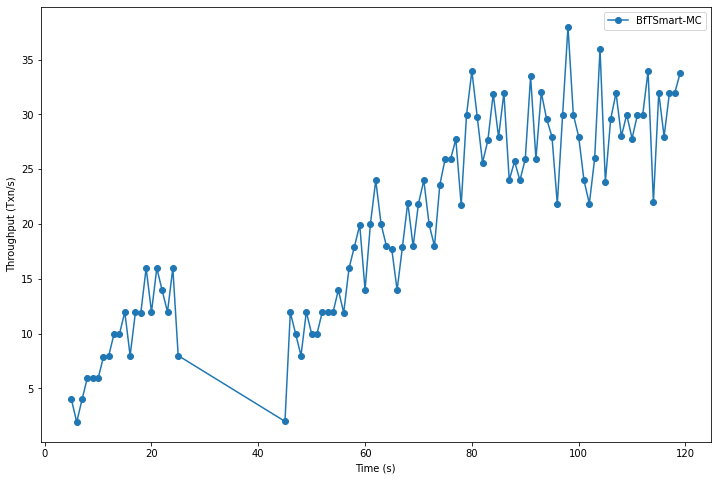

<Figure size 432x288 with 0 Axes>

In [25]:
import pylab as pl

pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
pl.plot(times[:], nclients*thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
pl.show()
pl.clf()


In [26]:
# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Joins Throughput')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()
